In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model loaded successfully with serving function


<ipython-input-6-7f35b21dd8ab>:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = int((prediction[output_key] > 0.5).numpy().astype(int))


Total errors during prediction: 0
Overall Accuracy on test dataset: 0.9713
Classification Report:


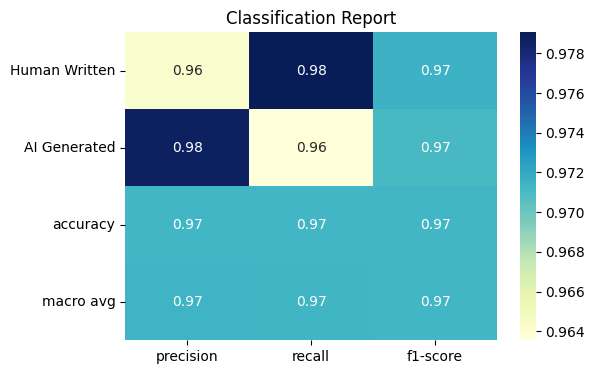

Confusion Matrix:


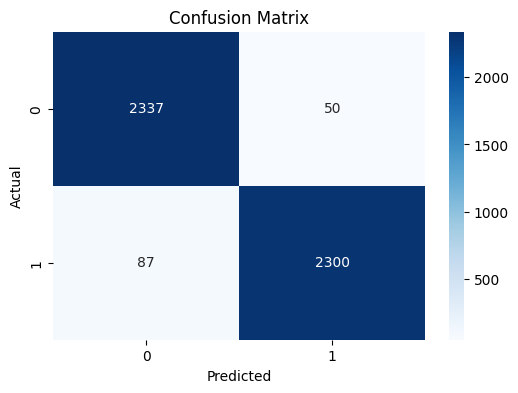

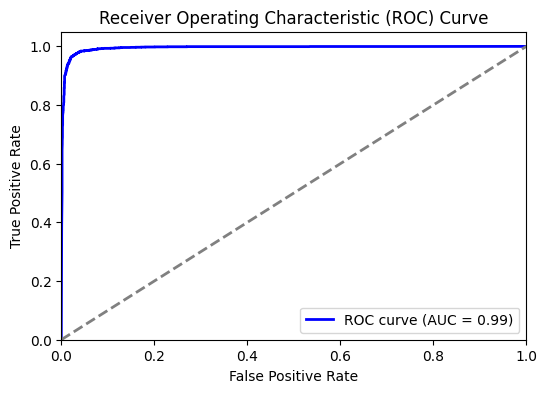

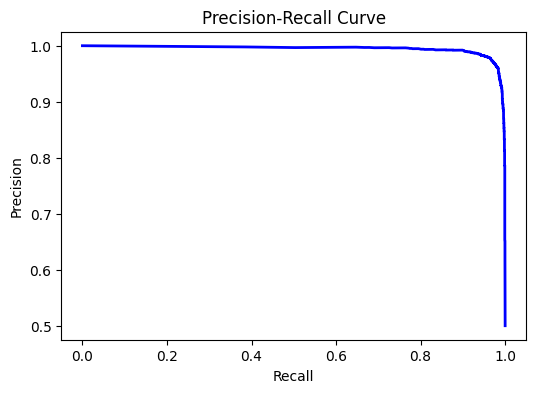

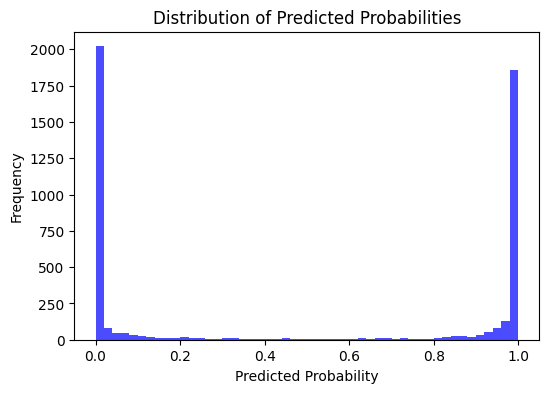

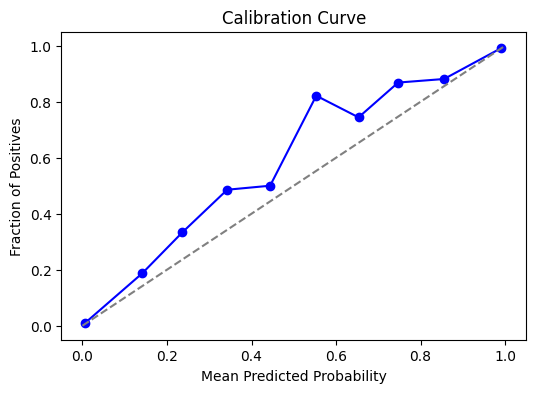

In [6]:
import tensorflow as tf
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.calibration import calibration_curve

# Mount Google Drive
# drive.mount('/content/drive')

# Unzip the model directory
model_zip_path = '/content/drive/MyDrive/ai_txt_detection_bertModel_epoch10EarlyFeatures.zip'  # Replace with your zip file path
model_extract_path = '/content/ai_txt_detection_bertModel_epoch10EarlyFeatures'
with zipfile.ZipFile(model_zip_path, 'r') as zip_ref:
    zip_ref.extractall(model_extract_path)

# Load the model
try:
    loaded_model = tf.saved_model.load(model_extract_path)
    inference_func = loaded_model.signatures['serving_default']
    print("Model loaded successfully with serving function")
except Exception as e:
    print(f"Error loading model: {e}")
    print(f"Contents of {model_extract_path}:", os.listdir(model_extract_path))
    raise

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_SEQ_LENGTH = 512

# Load and preprocess test data
test_df = pd.read_csv('/content/drive/MyDrive/test_set.csv')  # Replace with your test dataset path
test_df = test_df.dropna(subset=['text'])

# Shuffle the test dataset
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Fill NaN values in additional features
features = ['avg line length', 'word density', 'mean_perplexity', 'burstiness1', 'flesch_kincaid_score', 'gunning_fog_score']
for feature in features:
    test_df[feature].fillna(test_df[feature].mean(), inplace=True)

# Scale additional features
scaler = StandardScaler()
additional_features = scaler.fit_transform(test_df[features])

def batch_tokenize(texts, tokenizer, batch_size=32, max_length=MAX_SEQ_LENGTH):
    input_ids_list = []
    attention_mask_list = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
        input_ids_list.append(inputs['input_ids'])
        attention_mask_list.append(inputs['attention_mask'])
    input_ids = tf.concat(input_ids_list, axis=0)
    attention_masks = tf.concat(attention_mask_list, axis=0)
    return input_ids, attention_masks

def predict(text, additional_features):
    # Tokenize the input text
    input_ids, attention_masks = batch_tokenize([text], tokenizer)

    # Convert input_ids and attention_masks to int32
    input_ids = tf.cast(input_ids, tf.int32)
    attention_masks = tf.cast(attention_masks, tf.int32)

    # Prepare the inputs for the inference function
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'additional_features': tf.constant(additional_features.reshape(1, -1), dtype=tf.float32)
    }

    # Make the prediction using the model
    prediction = inference_func(**inputs)

    # Extract the output from the prediction
    output_key = list(prediction.keys())[0]
    predicted_label = int((prediction[output_key] > 0.5).numpy().astype(int))

    return predicted_label, prediction[output_key].numpy()

# Test the model with the entire test dataset
predictions = []
probabilities = []
errors = 0  # Count errors
for i, row in test_df.iterrows():
    try:
        predicted_label, prob = predict(row['text'], additional_features[i])
        predictions.append(predicted_label)
        probabilities.append(prob)
    except Exception as e:
        errors += 1
        print(f"Error during prediction for text {i+1}: {e}")
        print("Input shapes:")
        print("text length:", len(row['text']))
        print("additional_features shape:", additional_features[i].shape)

print(f"Total errors during prediction: {errors}")

# Calculate accuracy if 'label' column is present in the test dataset
if 'label' in test_df.columns:
    if len(predictions) > 0:
        y_true = test_df['label'].values[:len(predictions)]
        y_pred = np.array(predictions)
        y_proba = np.array(probabilities).flatten()

        accuracy = accuracy_score(y_true, y_pred)
        print(f"Overall Accuracy on test dataset: {accuracy:.4f}")

        # Classification report
        print("Classification Report:")
        report = classification_report(y_true, y_pred, target_names=['Human Written', 'AI Generated'], output_dict=True)
        df_report = pd.DataFrame(report).transpose()

        plt.figure(figsize=(6, 4))
        sns.heatmap(df_report.iloc[:-1, :].drop('support', axis=1).astype(float), annot=True, cmap='YlGnBu')
        plt.title('Classification Report')
        plt.show()

        # Confusion matrix
        print("Confusion Matrix:")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # ROC Curve and AUC Score
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_proba)

        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

        # Distribution of Predictions
        plt.figure(figsize=(6, 4))
        plt.hist(y_proba, bins=50, color='blue', alpha=0.7)
        plt.title('Distribution of Predicted Probabilities')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.show()

        # Calibration Curve
        prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)

        plt.figure(figsize=(6, 4))
        plt.plot(prob_pred, prob_true, marker='o', color='blue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve')
        plt.show()

        # Error Analysis: Misclassified Examples
        # misclassified_indices = np.where(y_true != y_pred)[0]

        # for index in misclassified_indices:
        #     print(f"Text: {test_df.loc[index, 'text']}")
        #     print(f"True Label: {y_true[index]}, Predicted Label: {y_pred[index]}")
        #     print(f"Features: {test_df.loc[index, features].values}")
        #     print("\n")

    else:
        print("No predictions were made; accuracy cannot be calculated.")
else:
    print("No 'label' column in the test dataset.")
